In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct, os

In [2]:
from utils.extract_utils import *
from utils.latticeeasy import *
from utils.gradient_utils import gradient_discrete
from utils.label_utils import get_labels, label_blobs

In [3]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
rc('text', usetex=True)
rc('image', cmap='gist_heat_r')
rc('axes', **{'titlesize': 11})

plt.rcParams['axes.axisbelow'] = True

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load data

In [16]:
output_dir = "/media/yangelaxue/23E7CCB1624D2A50/Colliding_Oscillons/alpha_beta-0.5_50_250.804626/osc2_128"
output_pardir = "/media/yangelaxue/23E7CCB1624D2A50/Colliding_Oscillons/alpha_beta-0.5_50"
data = LATTICEEASY(output_dir)
data.__dict__

{'output_dir': '/media/yangelaxue/23E7CCB1624D2A50/Colliding_Oscillons/alpha_beta-0.5_50_250.804626/osc2_128',
 'alpha': 0.5,
 'beta': 50.0,
 'phi_0': 0.118201,
 'dt_pr': 0.001,
 'domain_width_pr': array([0.365995, 0.365995, 0.365995]),
 'domain_dimensions': (128, 128, 128),
 't': array([ 0.499997,  1.500014,  2.000037,  2.999965,  3.999892,  4.99982 ,
         5.999747,  6.999675,  7.999603,  8.499805,  9.000008,  9.50021 ,
        10.000412, 10.500614, 11.000816, 11.501019, 12.001221, 12.501423,
        13.001625, 13.501827, 14.002029, 14.502232, 15.002434, 15.502636,
        16.002834, 17.002285, 18.001736, 19.001186, 20.000637, 21.000088,
        21.999538, 22.998989, 23.99844 , 24.99789 , 24.999889]),
 '_slice_tidx': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 'a': array([10.73867, 10.73867, 10.73867, 10.73867, 10.73867, 10.73867,
        10.73867, 10.73867, 10

In [5]:
timeslice = 0

a, ap = data.a[timeslice], data.ap[timeslice]

# dt_pr = data.dt_pr
# domain_width_pr = data.domain_width_pr
# domain_dimensions = data.domain_dimensions
# domain_width_pr, domain_dimensions

In [6]:
n_points = np.product(data.domain_dimensions)

grid_file = "osc2.img"
with open(os.path.join(output_dir,grid_file),'rb') as grid:
    
    grid_content = grid.read()
    
    phi = struct.unpack("f" * n_points, grid_content[16:16+4*n_points])
    phip = struct.unpack("f" * n_points, grid_content[16+4*n_points:])
    
phi = np.array(phi).reshape(data.domain_dimensions)
phip = np.array(phip).reshape(data.domain_dimensions)

phi = phi - data.dt_pr/2 * phip

In [7]:
Edens = get_Edens_pr(
    phi, phip, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=data.domain_width_pr/data.domain_dimensions
    )

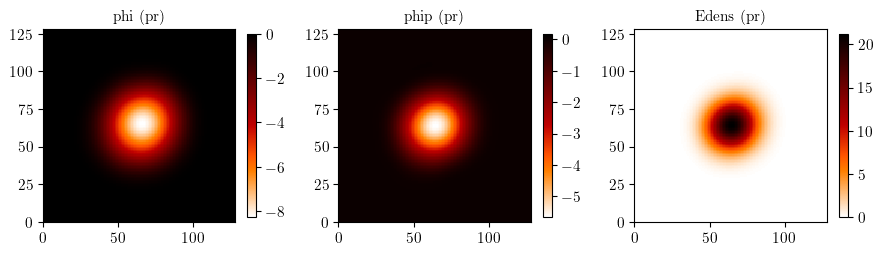

In [8]:
cross = 64

fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)

for ax in axes:
    ax.set_aspect('equal')

mesh = axes[0].pcolormesh(phi[:,cross],
              vmin=phi.min(), vmax=phi.max(),
              )
axes[0].set_title("phi (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[1].pcolormesh(phip[:,cross],
              vmin=phip.min(), vmax=phip.max(),
              )
axes[1].set_title("phip (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[2].pcolormesh(Edens[:,cross],
              vmin=Edens.min(), vmax=Edens.max(),
              )
axes[2].set_title("Edens (pr)")
fig.colorbar(mesh,shrink=.5)

plt.show()

# Add oscillon to background

In [9]:
pad = 128
shape_bg = tuple(dim_x+pad for dim_x in data.domain_dimensions)

if pad==0:
    phi_bg, phip_bg, Edens_bg = phi, phip, Edens
    print("skip background")
else:
    phi_bg, phip_bg = add_field_to_background(np.zeros(shape_bg), phi, phip)
    phi_bg, phip_bg, = smooth_edge(64, 0.2, 4, phi_bg, phip_bg)
    Edens_bg = get_Edens_pr(
        phi_bg, phip_bg, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=data.domain_width_pr/data.domain_dimensions
    )

In [10]:
domain_width_pr = data.domain_width_pr*shape_bg/data.domain_dimensions
data.domain_width_pr, domain_width_pr

(array([0.365995, 0.365995, 0.365995]), array([0.73199, 0.73199, 0.73199]))

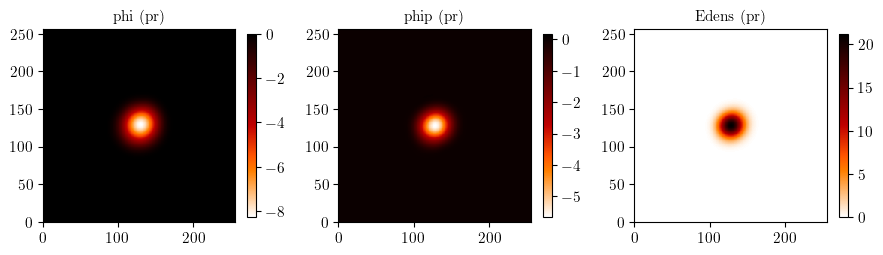

In [11]:
cross = shape_bg[0]//2

fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)

for ax in axes:
    ax.set_aspect('equal')

mesh = axes[0].pcolormesh(phi_bg[:,cross],
              vmin=phi.min(), vmax=phi.max(),
              )
axes[0].set_title("phi (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[1].pcolormesh(phip_bg[:,cross],
              vmin=phip.min(), vmax=phip.max(),
              )
axes[1].set_title("phip (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[2].pcolormesh(Edens_bg[:,cross],
              vmin=Edens.min(), vmax=Edens.max(),
              )
axes[2].set_title("Edens (pr)")
fig.colorbar(mesh,shrink=.5)

plt.show()

# Interpolate

In [12]:
# shape_i = (128,128,128)
shape_i = (256,256,256)
# shape_i = data.domain_dimensions

if shape_i==shape_bg:
    print("skip interpolate")
    phi_i, phip_i, Edens_i = phi_bg, phip_bg, Edens_bg
else:
    phi_i, phip_i, Edens_i = interpolate(shape_i, phi_bg, phip_bg, Edens_bg)
    
print(phi_i.shape)

skip interpolate
(256, 256, 256)


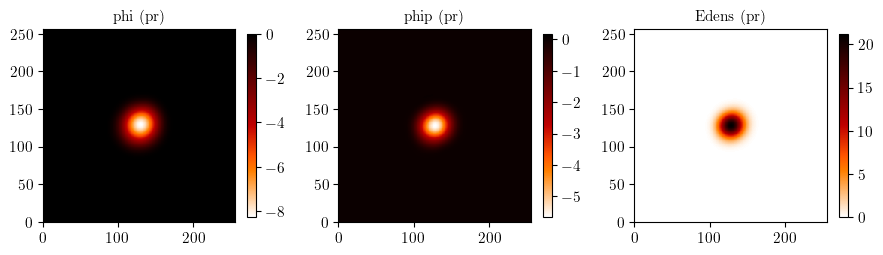

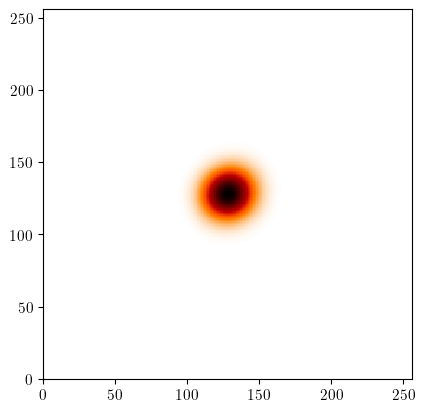

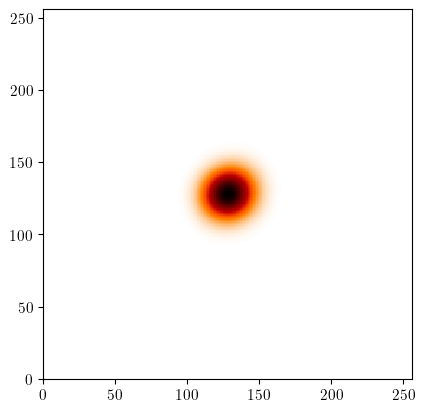

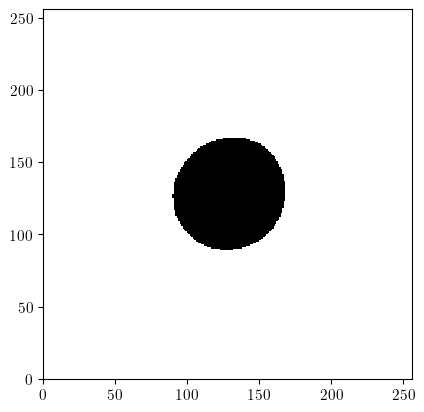

In [25]:
cross = shape_i[0]//2

fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)

for ax in axes:
    ax.set_aspect('equal')

mesh = axes[0].pcolormesh(phi_i[:,cross],
              vmin=phi.min(), vmax=phi.max(),
              )
axes[0].set_title("phi (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[1].pcolormesh(phip_i[:,cross],
              vmin=phip.min(), vmax=phip.max(),
              )
axes[1].set_title("phip (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[2].pcolormesh(Edens_i[:,cross],
              vmin=Edens.min(), vmax=Edens.max(),
              )
axes[2].set_title("Edens (pr)")
fig.colorbar(mesh,shrink=.5)

plt.show()

Edens_mean = load_energy(output_pardir, 4)[1:].sum()
mask_trial = Edens_i>Edens_mean/2**4

plt.pcolormesh((Edens_i*mask_trial)[:,cross])
plt.gca().set_aspect('equal')
plt.show()

plt.pcolormesh(Edens_i[:,cross])
plt.gca().set_aspect('equal')
plt.show()

plt.pcolormesh(mask_trial[:,cross])
plt.gca().set_aspect('equal')
plt.show()

## Shift oscillon to center

In [26]:
if 0:
    center = tuple(np.round(np.array([(Edens_i*x).sum() for x in np.indices(shape_i)])/Edens_i.sum()).astype(int))

    phi_sh, phip_sh, Edens_sh = shift_volume(center, phi_i, phip_i, Edens_i)
    
    cross = shape_i[0]//2

    fig, axes = plt.subplots(1,2,figsize=(6,4),tight_layout=True)

    for ax in axes:
        ax.set_aspect('equal')

    mesh = axes[0].pcolormesh(phi_sh[:,cross],
                  vmin=phi_i.min(), vmax=phi_i.max(),
                  )
    axes[0].set_title("phi (pr)")
    fig.colorbar(mesh,shrink=.5)

    mesh = axes[1].pcolormesh(phip_sh[:,cross],
                  vmin=phip_i.min(), vmax=phip_i.max(),
                  )
    axes[1].set_title("phip (pr)")
    fig.colorbar(mesh,shrink=.5)
else:
    phi_sh, phip_sh, Edens_sh = phi_i, phip_i, Edens_i

# Boost

In [27]:
c_pr = 1/a**(data.rescale_s+1) # Speed limit in code units
c_pr

0.008671595406120412

In [32]:
# """
# View momentum before applying boost.
# """
# vmax = Edens_sh.max()
# threshold = vmax/(6*np.exp(1))
# oscillons = label_blobs(Edens_sh, threshold, 1, True)
    
# labels = get_labels(oscillons)

# for label in labels:
#     mask = oscillons.copy()
#     mask = (mask==label).astype(int)
#     if vmax in Edens_sh*mask:
#         break

mask = np.ones(shape_i)
# mask = mask_trial

momenta_pr = get_momenta_pr(phi_sh, phip_sh, a, ap, data.alpha, data.beta, data.phi_0, domain_width_pr/shape_i)
field_speed_pr = get_field_speed_pr(momenta_pr*mask, Edens_sh*mask, a, data.alpha)

field_speed_pr/c_pr, momenta_pr.sum(axis=(1,2,3))

(array([-0.00997381,  0.00409966, -0.02433809]),
 array([ -493761.45733772,   202957.10320386, -1204876.33268597]))

In [40]:
# boost = np.array([0.042, -0.002625, 0.00573]) * c_pr # 128 res
# boost = np.array([0.042, -0.002625, 0.00573]) * c_pr # 256 res
# boost = np.array([0.3415, 0.1194, 0.01227]) * c_pr
boost = np.array([4., 0.0, 0.0]) * c_pr

grad = gradient_discrete(phi_sh, domain_width_pr/shape_i, stencil=5)
phip_sh_boost = phip_sh - np.sum([boost_x*grad_x for boost_x,grad_x in zip(boost,grad)],axis=0)

Edens_boost = get_Edens_pr(
    phi_sh, phip_sh_boost, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=domain_width_pr/shape_i
    )

momenta_pr_boost = get_momenta_pr(phi_sh, phip_sh_boost, a, ap, data.alpha, data.beta, data.phi_0, domain_width_pr/shape_i)
field_speed_pr_boost = get_field_speed_pr(momenta_pr_boost, Edens_boost, a, data.alpha)
field_speed_pr_boost/c_pr, momenta_pr_boost.sum(axis=(1,2,3))

(array([ 0.18575879,  0.02149949, -0.02676638]),
 array([14340404.95473788,  1659740.7282659 , -2066339.5825162 ]))

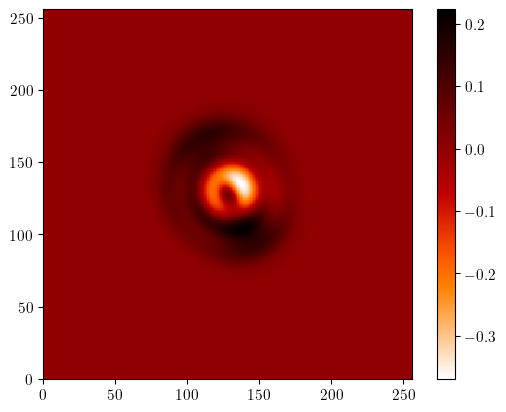

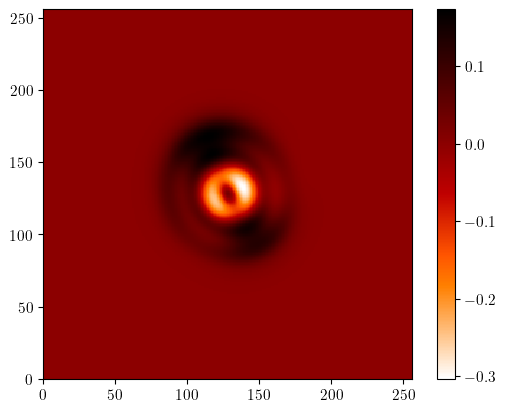

In [21]:
# plt.pcolormesh(grad[0][64],cmap="seismic")
# plt.gca().set_aspect('equal')
# plt.colorbar()
# plt.show()

plt.pcolormesh(phip_sh[shape_i[0]//2])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

plt.pcolormesh(phip_sh_boost[shape_i[0]//2])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

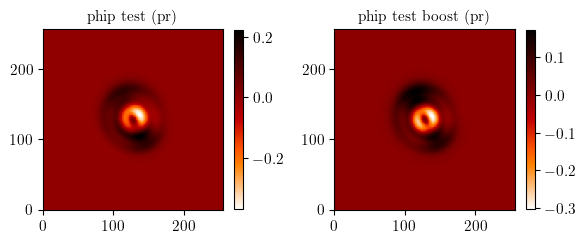

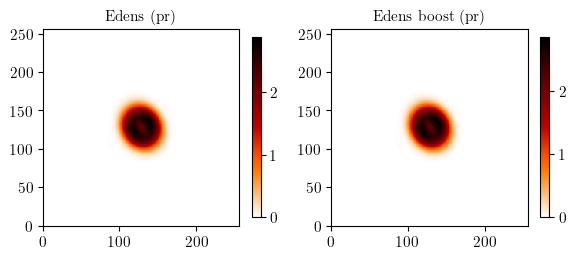

In [22]:
cross = shape_i[0]//2

fig, axes = plt.subplots(1,2,figsize=(6,2.9),tight_layout=True)

im = axes[0].pcolormesh(phip_sh[cross])
axes[0].set_title("phip test (pr)")
fig.colorbar(im,shrink=.7)

im = axes[1].pcolormesh(phip_sh_boost[cross])
axes[1].set_title("phip test boost (pr)")
fig.colorbar(im,shrink=.7)

for ax in axes:
    ax.set_aspect('equal')

plt.show()

fig, axes = plt.subplots(1,2,figsize=(6,2.9),tight_layout=True)

im = axes[0].pcolormesh(Edens_sh[cross])
axes[0].set_title("Edens (pr)")
fig.colorbar(im,shrink=.7)

im = axes[1].pcolormesh(Edens_boost[cross])
axes[1].set_title("Edens boost (pr)")
fig.colorbar(im,shrink=.7)

for ax in axes:
    ax.set_aspect('equal')

plt.show()

# Interpolate (again)

In [23]:
# shape_i_2 = (128,128,128)
shape_i_2 = (256,256,256)
# shape_i = data.domain_dimensions

if shape_i_2==shape_i:
    print("skip interpolate")
    phi_2, phip_2 = phi_sh, phip_sh_boost
else:
    phi_2, phip_2 = interpolate(shape_i_2, phi_sh, phip_sh_boost)
    Edens_2 = get_Edens_pr(
        phi_2, phip_2, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=domain_width_pr/shape_i_2
    )
    
    momenta_2 = get_momenta_pr(phi_2, phip_2, a, ap, data.alpha, data.beta, data.phi_0, domain_width_pr/shape_i_2)
    field_speed_2 = get_field_speed_pr(momenta_2, Edens_2, a, data.alpha)
    print(field_speed_2/c_pr)
    print(momenta_2.sum(axis=(1,2,3)))

skip interpolate


# Save data as grid.img

In [24]:
# dt_pr = data.dt_pr
dt_pr = 0.001

print(dt_pr)

phi_2_adv = phi_2 + dt_pr/2*phip_2

0.001


In [25]:
shape_i_2, domain_width_pr, dt_pr, data.phi_0, dt_pr/(domain_width_pr/shape_i_2)

((256, 256, 256),
 array([0.823908, 0.823908, 0.823908]),
 0.001,
 0.06424,
 array([0.3107143, 0.3107143, 0.3107143]))

In [26]:
n_points = np.product(shape_i_2)

fname_o = f"boost.img"
datname_o = f"boost.dat"
fdir = f"boost_0.005c_{shape_i_2[0]}"
# fname_o = f"highres_boost.img"
# datname_o = f"highres_boost.dat"
# fdir = f"highres_boost"
# fname_o = f"stationary.img"
# datname_o = f"stationary.dat"
# fdir = f"stationary_{shape_i[0]}"

# fname_o = f"cont.img"
# datname_o = f"cont.dat"
# fdir = f"./"
# fname_o = f"{fname}_noboost.img"
# datname_o = f"{fname}_noboost.dat"

if not os.path.exists(os.path.join(output_dir, fdir)):
    os.makedirs(os.path.join(output_dir, fdir))

with open(os.path.join(output_dir, fdir, datname_o), 'w') as dat:
    dat.write(f"N = {phi_2_adv.shape}\n")
    dat.write(f"L_pr = {domain_width_pr}\n")
    dat.write(f"dt_pr = {dt_pr}\n")
    dat.write(f"f0 = {data.phi_0}\n")
    dat.write(f"alpha = {data.alpha}\n")
    dat.write(f"beta = {data.beta}\n")
    dat.write(f"f0 = {data.phi_0}\n")
    dat.write(f"\n")
    
    dat.write(f"Boost given in x, y, z direction in code units is\n")
    dat.write(f"{boost/c_pr} x c_pr = {boost}\n")
    dat.write("Final average speed compared to c is\n")
    dat.write(f"{field_speed_pr_boost/c_pr} x c_pr = {field_speed_pr_boost} \n")
    
#     dat.write("\n")
#     dat.write("This was boosted first and then interpolated.\n")
    
#     if "boost" in fdir:
#         dat.write(f"Or .01c_pr in the x direction.\n")
    
#     if fdir=="highres_boost":
#         dat.write("\n")
#         dat.write(f"High resolution timesteps begins at t={data.t[timeslice]}\n")
    
    dat.write("\n")
    dat.write(f"{output_dir = }")

with open(os.path.join(output_dir, fdir, fname_o),'wb') as f_o:
    
    f_o.write(struct.pack('<i',-1))
#     f_o.write(struct.pack('<f',data.t[timeslice]))
    f_o.write(struct.pack('<f',0))
    f_o.write(struct.pack('<f',data.a[timeslice]))
    f_o.write(struct.pack('<f',data.ap[timeslice]))
    
    f_o.write(struct.pack('<'+'f'*n_points,*phi_2_adv.flatten()))
    f_o.write(struct.pack('<'+'f'*n_points,*phip_2.flatten()))